In [56]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

base_dir = '/ebs/.cache/ubuntu'
eval_dir = os.path.join(base_dir, 'eval_files')
os.makedirs(eval_dir, exist_ok=True)
save_win_dict = False
load_win_dict = False

In [57]:
def all_dirs_with_prefix(prefix):
    return [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith(prefix)]

all_sft_dirs = [os.path.join(cdir, p) for cdir in all_dirs_with_prefix('final_ds') for p in os.listdir(cdir) if p.startswith('epoch')]
base_eval_dir = ['/ebs/.cache/ubuntu/llama7b_samples/alpaca_eval_nsamples1_maxlen512']
all_dpo_dirs = [os.path.join(cdir, p) for cdir in all_dirs_with_prefix('DS_') for p in os.listdir(cdir) if p.startswith('epoch')]
eval_list = ['gpt4', 'claude_1', 'claude_2']

In [75]:
print(all_dpo_dirs)
winrate = {}
for cdir in all_dpo_dirs:
    try:
        name = open(os.path.join(cdir, 'name.txt')).read().splitlines()[0]
    except:
        continue
    print(name)
    winrate[name] = {}
    for eval in eval_list:
        try:
            leaderboard = open(os.path.join(cdir, eval, 'leaderboard.csv')).read().splitlines()
        except:
            continue
        for row in leaderboard:
            if row.split(',')[0] == name:
                print(f'{eval} score for {name}: {row.split(",")[1]}')
                winrate[name][eval] = float(row.split(",")[1])

['/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-6', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-9', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-12', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-6', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-9', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-12', '/ebs/.cache/ubuntu/DS_c2prefs0.5_llama7b_dpob0.05_sft0.1e3_2023-10-12_07-24-16_138480/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.5_llama7b_dpob0.05_sft0.1e3_2023-10-12_07-24-16_138480/epoch-6', '/ebs/.cache/ubuntu/DS_

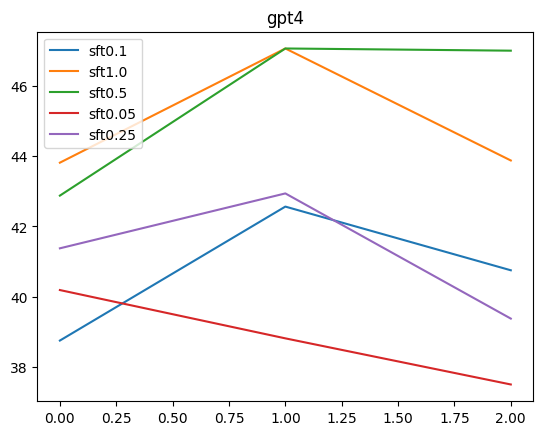

In [74]:
# save the winrate dict
if save_win_dict:
    with open(os.path.join(eval_dir,'sft_winrate.pkl'), 'wb') as f:
        pickle.dump(winrate, f)

if load_win_dict:
    winrate_addn = pickle.load(open(os.path.join(eval_dir, 'sft_winrate.pkl'), 'rb'))
    winrate = {**winrate, **winrate_addn}

winrate_per_model = {}
for key in winrate.keys():
    if key == 'llama7b_base':
        continue
    model_name = key[len('llama7b_'):-3]
    if model_name not in winrate_per_model.keys():
        winrate_per_model[model_name] = {}
    for eval in eval_list:
        if eval not in winrate_per_model[model_name].keys():
            winrate_per_model[model_name][eval] = []
        winrate_per_model[model_name][eval].append(winrate[key][eval])

# plot winrate for every model over training epochs
plt.figure()
for model_name in winrate_per_model.keys():
    for eval in ['gpt4']:
        plt.plot(winrate_per_model[model_name][eval], label=model_name)
    plt.legend()
    plt.title(eval)
    # plt.savefig(os.path.join(eval_dir, f'{model_name}_winrate.png'))

plt.show()
